# Deplatforming and Misinformation: Efficacy of Twitter's January 2021 User Suspensions

## Abstract

Using daily aggregate data from an anonymized replication dataset, this analysis evaluates whether Twitter’s Jan 6–12, 2021 suspension ramp is associated with changes in misinformation sharing among users who were not suspended. Outcomes are defined as rates (misinformation share per tweet and misinformation per active user) to reduce mechanical volume effects from account removals. A continuous exposure series captures the gradual nature of deplatforming, and a dynamic dose-response event-study specification estimates how the outcome–exposure relationship evolves around the suspension period.

Across specifications, higher suspension exposure is associated with a statistically significant reduction in the pooled misinformation share of tweets. The magnitude is stable across alternative control sets and reasonable choices of the pre/post window. The per-user outcome is directionally consistent but less precisely estimated. Heterogeneity analyses indicate that the association is concentrated in high-activity strata, consistent with the interpretation that changes in the high-volume portion of the ecosystem account for much of the aggregate decline.

At the same time, the intensity-weighted pre-period interaction coefficients are jointly significant, indicating detectable pre-period dynamics correlated with the exposure series. This weakens a strict parallel-trends-style causal interpretation and motivates caution: the evidence is strongly consistent with a post-period reduction in misinformation sharing aligned with the suspension ramp, but may also reflect concurrent time-varying factors around January 6 that covary with the exposure measure. Placebo timing checks and alternative exposure definitions (including a cumulative-removals functional form) help assess specification sensitivity, but cannot fully rule out confounding.

Overall, the findings support the view that large-scale deplatforming can reduce the prevalence of misinformation on the platform among remaining users, with the strongest associations appearing in high-activity groups.

## Introduction

This analysis builds on the study, *Post-January 6th deplatforming reduced the reach of misinformation on Twitter* (McCabe et al. 2024), which examined Twitter's large-scale account suspensions following the January 6th, 2021 insurrection. Noting the significant role misinformation and conspiracy theories played, Twitter and other social media platforms implemented sweeping account suspensions to prevent their spread.

The goal of this project is to replicate and extend the findings of McCabe et al. using an anonymized replication dataset provided by the authors. I aim to further susbtantiate their conclusions to gauge the actual efficacy of Twitter's post-January 6th user suspensions. By doing so, I hope to improve the understanding of how social media platforms can mitigate the spread of misinformation and its impact on public discourse.

## Modeling

The data are daily aggregates for multiple non-suspended user strata (e.g., misinformation-sharing groups by following patterns and activity levels). Because the treatment removes suspended accounts from the platform, raw counts mechanically fall when users are removed. To focus on behavioral change among remaining users, we define outcomes as rates: (i) the share of tweets that are misinformation-linked (“fake share per tweet”), and (ii) misinformation tweets per active user (“fake per user”). We then pool across non-suspended strata using appropriate weights (tweet volume or active users).

### Estimands

To isolate behavioral change from mechanical reductions in platform activity, all primary outcomes are defined as *rates* rather than raw volumes.

For each non-suspended user subset $s$ on day $t$:

**Fake share of activity (per tweet):**

$$[
y^{tweet}_{st} =
\frac{\text{fake merged initiation}_{st} + \text{fake merged rt}_{st}}
{\text{total tweets}_{st}}
]$$

**Fake per active user:**

$$[
y^{user}_{st} =
\frac{\text{fake merged initiation}_{st} + \text{fake merged rt}_{st}}
{\text{active users}_{st}}
]$$

The primary estimand is the causal effect of the January 6–12 suspension ramp on the misinformation rate among *non-suspended* users.

The main outcome is the pooled fake share per tweet across all non-suspended users. The per-user outcome is treated as secondary.

### Treatment Definition

Suspensions occurred gradually between January 6 and January 12, 2021. Rather than modeling treatment as a binary indicator, I construct a continuous exposure variable:

$$
S_t = 1 - \frac{\text{suspended users}_t}{\text{pre-suspension baseline}}
$$

This captures the fraction of suspended users removed relative to baseline levels immediately before January 6.

This “dose” specification reflects the gradual nature of deplatforming and allows identification of marginal changes in misinformation rates as suspension intensity increases.

I additionally include:

* A short pulse control for January 6–7.
* Day-of-week fixed effects.
* Controls for non-fake political and non-political content shares.
  
Let $T = $ January 12, 2021.

Define event time:
$$k_t = t - T$$

Event time is binned to $k_t \in [-60, 60] \text{ with } k=-1$ omitted.

The dynamic-dose-response specification is:
$$y_t = \alpha + \sum_{k\neq-1}\delta_k(1\{k_t=k\}\cdot S_t) + \beta S_t + \gamma\text{Pulse}_t + \theta X_t + \mu_{\text{dow}} + \epsilon_t$$

Where $\delta_k$ captures dynamic treatment intensity effects.

Pre-trends are tested via joint F-test on:
$$H_0: \delta_k = 0 \hspace{0.5cm} \forall k \leq 0$$

I include day-of-week fixed effects, a short Jan 6–7 pulse indicator, and controls for the composition of non-fake content categories to reduce confounding from shifting topical mix. Inference uses HAC standard errors for serial correlation and block bootstrap confidence intervals for event-study coefficients.

Because the exposure series may itself be correlated with other time-varying shocks around Jan 6–12, we interpret pre-period interaction tests and placebo checks as diagnostics rather than definitive proof of identification.

### Inference

Two inference procedures are used:

* **HAC (Newey–West)** standard errors to account for autocorrelation.
* **Block bootstrap** to construct confidence bands for event-study coefficients.

Results are substantively identical across both approaches; bootstrap intervals are reported in figures.

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import re, warnings, os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib_venn as venn
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date

warnings.filterwarnings(action="ignore")

In [69]:
DATA_PATH = "total.csv"

TREAT_START = pd.Timestamp("2021-01-06")
TREAT_END = pd.Timestamp("2021-01-12")
TREAT_REF = pd.Timestamp("2021-01-12")

WIN_PRE = 90
WIN_POST = 90

LEFT_BIN = -60
RIGHT_BIN = 60
OMIT_K = -1

MAXLAGS_HAC = 14
BLOCK_LEN = 7
BOOT_REPS = 800
SEED = 7
ALPHA = 0.05

SUBSETS_NON_SUSP = [
    "A_ha","A_ma","A_la",
    "D_ha","D_ma","D_la",
    "F_ha","F_ma","F_la",
    "nfns_ha","nfns_ma","nfns_la"
]

SUBSETS_SUSP = ["suspended_ha","suspended_ma","suspended_la"]

CONTROL_SETS = {
    "all": ["cons","lib","shop","sports"],
    "political_only": ["cons","lib"],
    "nonpolitical_only": ["shop","sports"],
    "none": []
}

CONTROL_GROUPS = ["cons","lib","shop","sports"]

def safe_div(a, b, eps=1e-12):
    return a / (b + eps)

def block_bootstrap_indices(n, block_len, rng):
    starts = np.arange(0, n, block_len)
    chosen = rng.choice(starts, size=len(starts), replace=True)
    idx = []
    for s in chosen:
        idx.extend(range(s, min(s + block_len, n)))
    return np.array(idx[:n], dtype=int)

def add_constant(X):
    return sm.add_constant(X, has_constant="add")

def as_numeric(df, cols):
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def ensure_all_columns(wide, subsets, value_cols):
    for s in subsets:
        for v in value_cols:
            col = f"{v}_{s}"
            if col not in wide.columns:
                wide[col] = 0.0
    return wide

def make_event_time(df, ref_date):
    return (df.index - ref_date).days.astype(int)

def make_ramp(df_index, start, end):
    ramp_num = (df_index - start).days.astype(float)
    ramp_den = float((end - start).days)
    return np.clip(ramp_num / ramp_den, 0.0, 1.0)

def format_p(p):
    if p is None or not np.isfinite(p):
        return ""
    if p < 1e-3:
        return "<0.001"
    return f"{p:.3f}"

def star(p):
    if p is None or not np.isfinite(p):
        return ""
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    return ""

def fmt_coef_se(coef, se, p):
    if coef is None or se is None or not np.isfinite(coef) or not np.isfinite(se):
        return ""
    return f"{coef:.4f}{star(p)} ({se:.4f})"

def extract_term(model, cols, term):
    if model is None or cols is None or term not in cols:
        return None, None, None
    j = cols.index(term)
    return float(model.params[j]), float(model.bse[j]), float(model.pvalues[j])

In [70]:
# data preparation
def load_and_pivot_total(path):
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["date"])
    df["stat"] = df["stat"].astype(str).str.lower()
    df["subsets"] = df["subsets"].astype(str)

    df = df[df["stat"] == "total"].copy()
    df = df.dropna(subset=["date", "subsets"]).copy()

    value_cols = [
        "fake_merged_initiation","fake_merged_rt",
        "not_fake_conservative_initiation","not_fake_conservative_rt",
        "not_fake_liberal_initiation","not_fake_liberal_rt",
        "not_fake_shopping_initiation","not_fake_shopping_rt",
        "not_fake_sports_initiation","not_fake_sports_rt",
        "n","nusers"
    ]
    df = as_numeric(df, value_cols)
    df = df.sort_values(["date","subsets"])

    wide = df.pivot_table(index="date", columns="subsets", values=value_cols, aggfunc="sum")
    wide.columns = [f"{v}_{s}" for v, s in wide.columns]
    wide = wide.sort_index()
    wide = wide.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    wide = ensure_all_columns(wide, SUBSETS_NON_SUSP + SUBSETS_SUSP, value_cols)
    wide = wide.sort_index()

    return wide, value_cols

In [71]:
# window construction
def add_cumulative_suspensions(w, pre_baseline):
    w["susp_removed_raw"] = (pre_baseline - w["susp_nusers"]).clip(lower=0.0)
    w["susp_removed_cum"] = w["susp_removed_raw"].cummax()
    denom = max(float(pre_baseline), 1.0)
    w["susp_removed_cum_scaled"] = (w["susp_removed_cum"] / denom).clip(0.0, 1.0)

    return w

def build_window_frame(wide, ref_date, start_treat, win_pre, win_post):
    start_window = ref_date - pd.Timedelta(days=win_pre)
    end_window   = ref_date + pd.Timedelta(days=win_post)

    w = wide.loc[(wide.index >= start_window) & (wide.index <= end_window)].copy()

    w["dow"] = w.index.dayofweek.astype(int)
    w["k"] = (w.index - ref_date).days.astype(int)
    w["k_bin"] = w["k"].clip(LEFT_BIN, RIGHT_BIN).astype(int)

    w["ramp"] = make_ramp(w.index, start_treat, ref_date)

    w["pulse_jan6_7"] = ((w.index >= pd.Timestamp("2021-01-06")) &
                         (w.index <= pd.Timestamp("2021-01-07"))).astype(int)

    w["susp_nusers"] = (
        w["nusers_suspended_ha"] +
        w["nusers_suspended_ma"] +
        w["nusers_suspended_la"]
    )

    pre_series = wide.loc[
        wide.index < start_treat,
        ["nusers_suspended_ha","nusers_suspended_ma","nusers_suspended_la"]
    ].sum(axis=1)

    pre_baseline = pre_series.tail(14).mean()
    if not np.isfinite(pre_baseline) or pre_baseline <= 0:
        pre_baseline = max(pre_series.mean(), 1.0)

    w["susp_intensity"] = 1.0 - (w["susp_nusers"] / pre_baseline)
    w["susp_intensity"] = w["susp_intensity"].clip(0.0, 1.0)
    w = add_cumulative_suspensions(w, pre_baseline)

    return w

In [72]:
# outcomes and controls
def construct_outcomes_and_controls(w):
    for subset in SUBSETS_NON_SUSP:
        fi = f"fake_merged_initiation_{subset}"
        fr = f"fake_merged_rt_{subset}"

        cci = f"not_fake_conservative_initiation_{subset}"
        ccr = f"not_fake_conservative_rt_{subset}"
        lli = f"not_fake_liberal_initiation_{subset}"
        llr = f"not_fake_liberal_rt_{subset}"
        shi = f"not_fake_shopping_initiation_{subset}"
        shr = f"not_fake_shopping_rt_{subset}"
        spi = f"not_fake_sports_initiation_{subset}"
        spr = f"not_fake_sports_rt_{subset}"

        ncol = f"n_{subset}"
        ucol = f"nusers_{subset}"

        w[f"fake_total_{subset}"] = w[fi] + w[fr]
        w[f"nf_cons_total_{subset}"] = w[cci] + w[ccr]
        w[f"nf_lib_total_{subset}"] = w[lli] + w[llr]
        w[f"nf_shop_total_{subset}"] = w[shi] + w[shr]
        w[f"nf_sports_total_{subset}"] = w[spi] + w[spr]

        w[f"y_fake_share_tweet_{subset}"] = safe_div(w[f"fake_total_{subset}"], w[ncol])
        w[f"y_fake_per_user_{subset}"] = safe_div(w[f"fake_total_{subset}"], w[ucol])

        w[f"c_cons_tweet_{subset}"] = safe_div(w[f"nf_cons_total_{subset}"], w[ncol])
        w[f"c_lib_tweet_{subset}"]  = safe_div(w[f"nf_lib_total_{subset}"],  w[ncol])
        w[f"c_shop_tweet_{subset}"] = safe_div(w[f"nf_shop_total_{subset}"], w[ncol])
        w[f"c_sports_tweet_{subset}"] = safe_div(w[f"nf_sports_total_{subset}"], w[ncol])

        w[f"c_cons_user_{subset}"] = safe_div(w[f"nf_cons_total_{subset}"], w[ucol])
        w[f"c_lib_user_{subset}"]  = safe_div(w[f"nf_lib_total_{subset}"],  w[ucol])
        w[f"c_shop_user_{subset}"] = safe_div(w[f"nf_shop_total_{subset}"], w[ucol])
        w[f"c_sports_user_{subset}"] = safe_div(w[f"nf_sports_total_{subset}"], w[ucol])

    return w

def pooled_outcome(w, kind="tweet", subsets=None):
    if subsets is None:
        subsets = SUBSETS_NON_SUSP

    parts = []
    weights = []
    for subset in subsets:
        if kind == "tweet":
            y = w[f"y_fake_share_tweet_{subset}"]
            wt = w[f"n_{subset}"]
        else:
            y = w[f"y_fake_per_user_{subset}"]
            wt = w[f"nusers_{subset}"]
        parts.append(y * wt)
        weights.append(wt)
    return safe_div(sum(parts), sum(weights))

def pooled_controls(w, kind="tweet", subsets=None):
    if subsets is None:
        subsets = SUBSETS_NON_SUSP

    ctrl = {}
    for g in CONTROL_GROUPS:
        parts = []
        weights = []
        for subset in subsets:
            if kind == "tweet":
                c = w[f"c_{g}_tweet_{subset}"]
                wt = w[f"n_{subset}"]
            else:
                c = w[f"c_{g}_user_{subset}"]
                wt = w[f"nusers_{subset}"]
            parts.append(c * wt)
            weights.append(wt)
        ctrl[g] = safe_div(sum(parts), sum(weights))
    return pd.DataFrame(ctrl, index=w.index)

In [73]:
# design matrix
def make_k_dummies(w):
    k_d = pd.get_dummies(w["k_bin"].astype(int), prefix="k")
    omit = f"k_{OMIT_K}"
    if omit in k_d.columns:
        k_d = k_d.drop(columns=[omit])
    k_cols = list(k_d.columns)
    return k_d, k_cols

def make_dow_dummies(w):
    return pd.get_dummies(w["dow"].astype(int), prefix="dow", drop_first=True)

def build_X(w, y_kind="tweet", include_controls=True, include_k=True,control_set_name="all", subsets=None, exposure_col='susp_intensity'):

    if subsets is None:
        subsets = SUBSETS_NON_SUSP

    parts = []
    k_cols = []
    int_cols = []

    # Event-time dummies
    if include_k:
        k_d, k_cols = make_k_dummies(w)

        # Interaction terms: k × suspension intensity
        for col in k_cols:
            int_name = f"{col}_x_intensity"
            k_d[int_name] = k_d[col] * w[exposure_col]
            int_cols.append(int_name)

        parts.append(k_d[int_cols])

    parts.append(w[[exposure_col,"pulse_jan6_7"]].copy())

    if include_controls and control_set_name != "none":
        C = pooled_controls(w, kind=y_kind, subsets=subsets)
        use = CONTROL_SETS.get(control_set_name, CONTROL_SETS["all"])
        parts.append(C[use])

    parts.append(make_dow_dummies(w))

    X = pd.concat(parts, axis=1)
    X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    X = X.loc[:, X.nunique(dropna=True) > 1]

    return X, k_cols, int_cols


In [74]:
# modeling
def fit_ols_hac(y, X, maxlags=MAXLAGS_HAC):
    y = pd.to_numeric(y, errors="coerce").replace([np.inf, -np.inf], np.nan)
    tmp = pd.concat([y.rename("y"), X], axis=1).dropna()

    yv = tmp["y"].astype(float).values
    Xdf = tmp.drop(columns=["y"]).astype(float)
    Xv = add_constant(Xdf.values)

    if Xv.shape[0] <= Xv.shape[1]:
        return None, None

    m = sm.OLS(yv, Xv).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
    cols = ["const"] + list(Xdf.columns)
    return m, cols

def coef_summary(model, cols, terms):
    rows = []
    if model is None or cols is None:
        for t in terms:
            rows.append({"term": t, "coef": np.nan, "se": np.nan, "p": np.nan})
        return pd.DataFrame(rows)

    for t in terms:
        if t in cols:
            j = cols.index(t)
            rows.append({"term": t,
                         "coef": float(model.params[j]),
                         "se": float(model.bse[j]),
                         "p": float(model.pvalues[j])})
        else:
            rows.append({"term": t, "coef": np.nan, "se": np.nan, "p": np.nan})
    return pd.DataFrame(rows)

def joint_pretrend_test(model, cols, interaction_cols):
    if model is None or cols is None:
        return None

    pre = [
        c for c in interaction_cols
        if c in cols and int(c.split("_")[1]) < 0
    ]

    if len(pre) == 0:
        return None
    idx = [cols.index(c) for c in pre]
    R = np.zeros((len(idx), len(cols)))

    for i, j in enumerate(idx):
        R[i, j] = 1.0
    r = np.zeros(len(idx))
    ft = model.f_test((R, r))

    return float(ft.pvalue)


def block_bootstrap_params(y, X, reps=BOOT_REPS, block_len=BLOCK_LEN, seed=SEED):
    rng = np.random.default_rng(seed)

    y = pd.to_numeric(y, errors="coerce").replace([np.inf, -np.inf], np.nan)
    tmp = pd.concat([y.rename("y"), X], axis=1).dropna()

    yv = tmp["y"].astype(float).values
    Xdf = tmp.drop(columns=["y"]).astype(float)
    Xv = add_constant(Xdf.values)

    cols = ["const"] + list(Xdf.columns)

    n = len(yv)
    if n < 30 or Xv.shape[0] <= Xv.shape[1]:
        return None, cols

    params = []
    for _ in range(reps):
        bidx = block_bootstrap_indices(n, block_len, rng)
        try:
            mb = sm.OLS(yv[bidx], Xv[bidx, :]).fit()
            params.append(mb.params)
        except Exception:
            continue

    if len(params) < max(100, reps // 4):
        return None, cols

    return np.asarray(params), cols

def event_study_ci_from_boot(P, cols, interaction_cols, alpha=ALPHA):
    if P is None or cols is None:
        return None

    col_to_idx = {c:i for i,c in enumerate(cols)}

    ks = []
    idxs = []

    for c in interaction_cols:
        if c in col_to_idx:
            k_val = int(c.split("_")[1])
            ks.append(k_val)
            idxs.append(col_to_idx[c])

    if len(ks) == 0:
        return None

    ks = np.array(ks, dtype=int)
    B = P[:, idxs]

    lo  = np.quantile(B, alpha/2, axis=0)
    hi  = np.quantile(B, 1 - alpha/2, axis=0)
    mid = np.quantile(B, 0.5, axis=0)

    order = np.argsort(ks)

    return pd.DataFrame({
        "k": ks[order],
        "mid": mid[order],
        "lo": lo[order],
        "hi": hi[order],
    })


In [75]:
def plot_event_study(es_df, title):
    plt.figure(figsize=(10, 4))
    plt.axhline(0, linewidth=1)
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.axvspan(-6, 0, alpha=0.12)

    plt.fill_between(es_df["k"], es_df["lo"], es_df["hi"], alpha=0.2)
    plt.plot(es_df["k"], es_df["mid"], marker="o", linewidth=1)
    plt.title(title)
    plt.xlabel("Days relative to Jan 12, 2021")
    plt.ylabel("Interaction coefficient (k x exposure)")
    plt.tight_layout()
    plt.show()


In [76]:
# heterogeneity
def pooled_subsets_by_activity(activity_suffix):
    return [s for s in SUBSETS_NON_SUSP if s.endswith(activity_suffix)]

In [77]:
# placebo
def run_placebo(wide):
    placebo_ref = pd.Timestamp("2020-10-15")
    placebo_start = pd.Timestamp("2020-10-09")

    wp = build_window_frame(wide, placebo_ref, placebo_start, WIN_PRE, WIN_POST)
    wp["pulse_jan6_7"] = 0
    wp["susp_intensity"] = make_ramp(wp.index, placebo_start, placebo_ref)


    wp = construct_outcomes_and_controls(wp)

    y = pooled_outcome(wp, kind="tweet")

    X, k_cols, int_cols = build_X(wp, y_kind="tweet", include_controls=True, include_k=True, control_set_name="all")

    m, cols = fit_ols_hac(y, X, maxlags=MAXLAGS_HAC)
    pre_p = joint_pretrend_test(m, cols, int_cols)

    P, cols_b = block_bootstrap_params(y, X, reps=BOOT_REPS, block_len=BLOCK_LEN, seed=SEED + 42)
    es = event_study_ci_from_boot(P, cols_b, int_cols, alpha=ALPHA)

    if es is not None:
        plot_event_study(es, title=f"PLACEBO | Pooled non-suspended | Fake share per tweet | Pretrend p={format_p(pre_p)}")

    return pre_p

In [78]:
def make_table_2_heterogeneity(w):
    rows = []
    for suf, label in [("ha", "High activity"),
                       ("ma", "Moderate activity"),
                       ("la", "Low activity")]:

        subs = pooled_subsets_by_activity(suf)

        y = pooled_outcome(w, kind="tweet", subsets=subs)

        X, k_cols, int_cols = build_X(w, y_kind="tweet", include_controls=True, include_k=True, control_set_name="all", subsets=subs)

        model, cols = fit_ols_hac(y, X, maxlags=MAXLAGS_HAC)

        coef, se, p = extract_term(model, cols, "susp_intensity")
        pre_p = joint_pretrend_test(model, cols, int_cols)

        rows.append({
            "Activity level": label,
            "susp_intensity (coef, SE)": fmt_coef_se(coef, se, p),
            "Pretrend p-value": format_p(pre_p)
        })

    return pd.DataFrame(rows)

def make_table_3_window_sensitivity():
    wide, _ = load_and_pivot_total(DATA_PATH)

    rows = []
    for win in [60, 90]:
        w_win = build_window_frame(wide, TREAT_REF, TREAT_START, win, win)
        w_win = construct_outcomes_and_controls(w_win)

        y = pooled_outcome(w_win, kind="tweet")

        X, _, _ = build_X(w_win, y_kind="tweet", include_controls=True, include_k=False, control_set_name="all")

        model, cols = fit_ols_hac(y, X, maxlags=MAXLAGS_HAC)
        coef, se, p = extract_term(model, cols, "susp_intensity")

        rows.append({
            "Window (± days)": win,
            "susp_intensity (coef, SE)": fmt_coef_se(coef, se, p)
        })

    return pd.DataFrame(rows)

def make_table_4_control_robustness(w):
    rows = []

    y = pooled_outcome(w, kind="tweet")
    for name, controls in CONTROL_SETS.items():

        X_parts = []
        X_parts.append(w[["susp_intensity","pulse_jan6_7"]])

        if name != "none":
            C = pooled_controls(w, kind="tweet")
            X_parts.append(C[controls])

        X_parts.append(make_dow_dummies(w))

        X = pd.concat(X_parts, axis=1)
        X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
        X = X.loc[:, X.nunique(dropna=True) > 1]

        model, cols = fit_ols_hac(y, X, maxlags=MAXLAGS_HAC)
        coef, se, p = extract_term(model, cols, "susp_intensity")

        rows.append({
            "Controls": name,
            "susp_intensity (coef, SE)": fmt_coef_se(coef, se, p)
        })

    return pd.DataFrame(rows)

In [79]:
wide, value_cols = load_and_pivot_total(DATA_PATH)
w = build_window_frame(wide, TREAT_REF, TREAT_START, WIN_PRE, WIN_POST)
w = construct_outcomes_and_controls(w)

y_tweet = pooled_outcome(w, kind="tweet")
y_user = pooled_outcome(w, kind="user")

X_tweet, k_cols_tweet, int_cols_tweet = build_X(w, y_kind="tweet", include_controls=True, include_k=True, control_set_name="all")
X_user, k_cols_user, int_cols_user = build_X(w, y_kind="user", include_controls=True, include_k=True, control_set_name="all")

m_tweet, cols_tweet = fit_ols_hac(y_tweet, X_tweet, maxlags=MAXLAGS_HAC)
m_user, cols_user = fit_ols_hac(y_user, X_user, maxlags=MAXLAGS_HAC)

pre_p_tweet = joint_pretrend_test(m_tweet, cols_tweet, int_cols_tweet)
pre_p_user = joint_pretrend_test(m_user, cols_user, int_cols_user)

P_tweet, cols_bt = block_bootstrap_params(y_tweet, X_tweet, reps=BOOT_REPS, block_len=BLOCK_LEN, seed=SEED)
P_user, cols_bu = block_bootstrap_params(y_user, X_user, reps=BOOT_REPS, block_len=BLOCK_LEN, seed=SEED + 1)

es_tweet = event_study_ci_from_boot(P_tweet, cols_bt, int_cols_tweet, alpha=ALPHA)
es_user = event_study_ci_from_boot(P_user, cols_bu, int_cols_user, alpha=ALPHA)

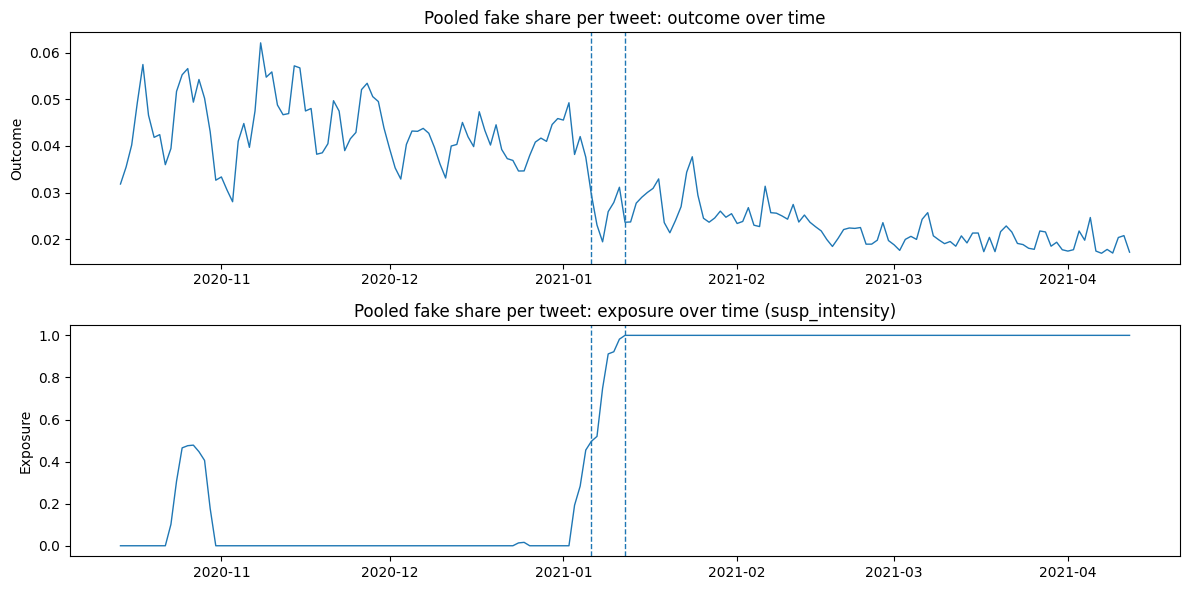

In [80]:
def plot_outcome_and_exposure(w, y, exposure_col, title):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(w.index, y, linewidth=1)
    ax1.axvline(TREAT_START, linestyle="--", linewidth=1)
    ax1.axvline(TREAT_REF, linestyle="--", linewidth=1)
    ax1.set_title(f"{title}: outcome over time")
    ax1.set_ylabel("Outcome")

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(w.index, w[exposure_col], linewidth=1)
    ax2.axvline(TREAT_START, linestyle="--", linewidth=1)
    ax2.axvline(TREAT_REF, linestyle="--", linewidth=1)
    ax2.set_title(f"{title}: exposure over time ({exposure_col})")
    ax2.set_ylabel("Exposure")
    plt.tight_layout()
    plt.show()

y_tweet = pooled_outcome(w, kind="tweet")
plot_outcome_and_exposure(w, y_tweet, "susp_intensity", "Pooled fake share per tweet")

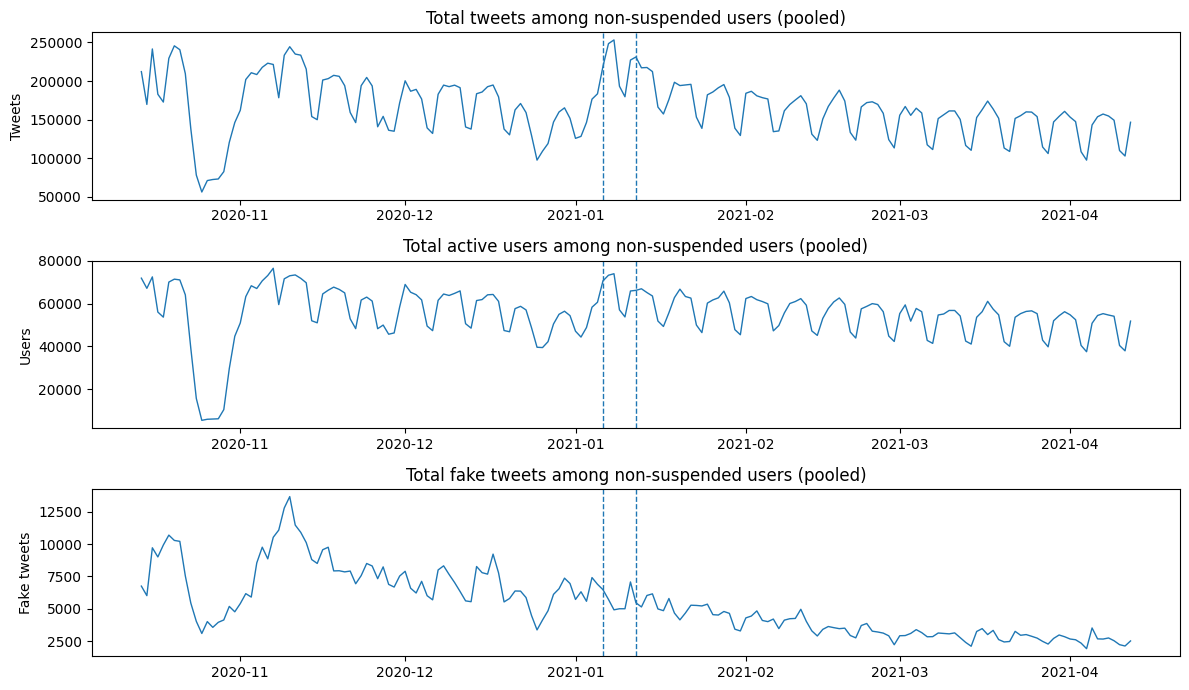

In [81]:
def plot_volume_channels(w, subsets=None):
    if subsets is None:
        subsets = SUBSETS_NON_SUSP

    total_tweets = sum(w[f"n_{s}"] for s in subsets)
    total_users = sum(w[f"nusers_{s}"] for s in subsets)
    total_fake = sum(w[f"fake_total_{s}"] for s in subsets)

    fig = plt.figure(figsize=(12, 7))
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(w.index, total_tweets, linewidth=1)
    ax1.axvline(TREAT_START, linestyle="--", linewidth=1)
    ax1.axvline(TREAT_REF, linestyle="--", linewidth=1)
    ax1.set_title("Total tweets among non-suspended users (pooled)")
    ax1.set_ylabel("Tweets")

    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(w.index, total_users, linewidth=1)
    ax2.axvline(TREAT_START, linestyle="--", linewidth=1)
    ax2.axvline(TREAT_REF, linestyle="--", linewidth=1)
    ax2.set_title("Total active users among non-suspended users (pooled)")
    ax2.set_ylabel("Users")

    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(w.index, total_fake, linewidth=1)
    ax3.axvline(TREAT_START, linestyle="--", linewidth=1)
    ax3.axvline(TREAT_REF, linestyle="--", linewidth=1)
    ax3.set_title("Total fake tweets among non-suspended users (pooled)")
    ax3.set_ylabel("Fake tweets")

    plt.tight_layout()
    plt.show()

plot_volume_channels(w)

## Results

In [82]:
terms_interest = ["susp_intensity", "pulse_jan6_7"]
summ_tweet = coef_summary(m_tweet, cols_tweet, terms_interest)
summ_user = coef_summary(m_user, cols_user, terms_interest)
summ_tweet["outcome"] = "fake_share_per_tweet (pooled)"
summ_user["outcome"] = "fake_per_user (pooled)"
summ = pd.concat([summ_tweet, summ_user], axis=0, ignore_index=True)

print("\n--- Main coefficient summaries (OLS HAC) ---")
print(summ)


--- Main coefficient summaries (OLS HAC) ---
             term      coef        se         p                        outcome
0  susp_intensity -0.015641  0.003392  0.000004  fake_share_per_tweet (pooled)
1    pulse_jan6_7 -0.005946  0.001648  0.000309  fake_share_per_tweet (pooled)
2  susp_intensity -0.014800  0.006596  0.024844         fake_per_user (pooled)
3    pulse_jan6_7 -0.011256  0.004293  0.008740         fake_per_user (pooled)


The Jan 6-7 pulse coefficient is -0.006, indicating an additional short-run shift during Jan 6-7 not explained by the intensity measure (and likely capturing acute platform-wide disruption/attention shifts around the event).

We estimate a negative association between suspension intensity and the pooled fake-share rate among non-suspended users. A full-scale increase in intensity corresponds to about a 1.6 percentage-point lower fake-share rate, conditional on controls and day-of-week fixed effects. However, the intensity-weighted pretrend test is strongly rejected, implying detectable pre-period dynamics correlated with intensity. Accordingly, we interpret the post-period decline as consistent with an effect of deplatforming, but not as cleanly identified by a parallel-trends-style argument in this specification.

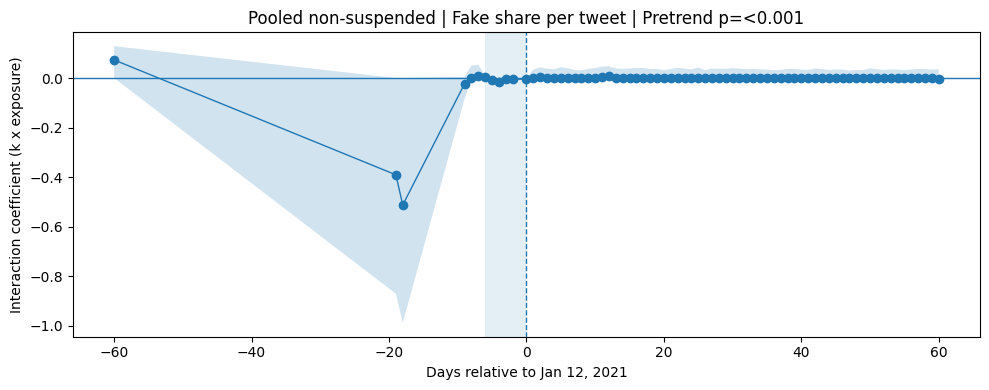

In [83]:
plot_event_study(es_tweet, title=f"Pooled non-suspended | Fake share per tweet | Pretrend p={format_p(pre_p_tweet)}")

In the pooled tweet-rate specification, the estimated coefficient on suspension intensity is -0.0156 (SE 0.0034, p < 0.001). Because the outcome is a rate (fake tweets / total tweets), this coefficient is a level effect on the fake-share rate. Interpreted literally, moving from 0 to 1 on the intensity scale (from "baseline suspended-user presence" to "full removal relative to baseline") corresponds to about a 1.56 percentage-point lower fake share of tweets among non-suspended users, holding controls and day-of-week fixed effects constant.

However, the joint pretend test p-value is extremely small, so we reject the null that all pre-period intensity interactions are jointly zero. While the results are consistent with a period decline associated with intensity, parallel trends are not supported by the model. This is not unexpected given that the suspended users "received treatment" based on their observed behavior.

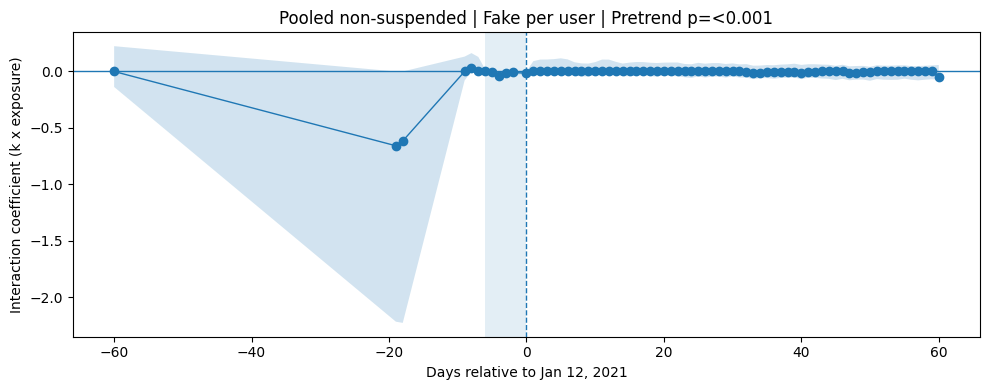

In [84]:
plot_event_study(es_user,  title=f"Pooled non-suspended | Fake per user | Pretrend p={format_p(pre_p_user)}")

The per-user specification points in the same direction but is slightly less precisely-estimated. This provides suggestive evidence that intensity is associated with reduced misinformation per remaining active user, though inference is weaker than for the tweet-share outcome and pre-period intensity interactions are again jointly significant

In [85]:
res = summ.loc[summ["term"] == "susp_intensity", ["outcome", "coef", "se", "p"]].copy()
res["pretrend_p"] = [pre_p_tweet, pre_p_user]
print("\n--- Main susp_intensity rows ---")
print(res)


--- Main susp_intensity rows ---
                         outcome      coef        se         p    pretrend_p
0  fake_share_per_tweet (pooled) -0.015641  0.003392  0.000004  1.323511e-53
2         fake_per_user (pooled) -0.014800  0.006596  0.024844  4.128766e-75


In [86]:
table2 = make_table_2_heterogeneity(w)
print("\n--- Table 2: Heterogeneity ---")
print(table2)


--- Table 2: Heterogeneity ---
      Activity level susp_intensity (coef, SE) Pretrend p-value
0      High activity       -0.0313*** (0.0020)           <0.001
1  Moderate activity          -0.0059 (0.0033)           <0.001
2       Low activity          -0.0048 (0.0046)           <0.001


The association between intensity and misinformation increases with user activity level. The implied change for high-activity users is about 3.1 percentage points across the full intensity scale, roughly twice the pooled estimate.

### Model Diagnostics

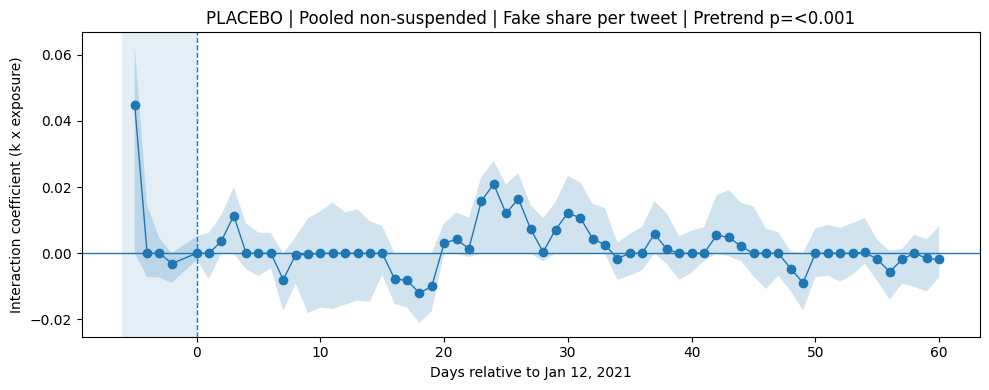

In [87]:
_ = run_placebo(wide)

While placebo intensity is a synthetic ramp, and therefore not definitive causal validation, it does support that the modeled results are specific to the suspension event.

In [88]:
table3 = make_table_3_window_sensitivity()
print("\n--- Window Sensitivity ---")
print(table3)


--- Window Sensitivity ---
   Window (± days) susp_intensity (coef, SE)
0               60       -0.0184*** (0.0014)
1               90       -0.0215*** (0.0018)


The estimated intensity association is stable and negative, slightly increasing in effect magnitude after a longer period.

In [89]:
table4 = make_table_4_control_robustness(w)
print("\n--- Control Robustness ---")
print(table4)


--- Control Robustness ---
            Controls susp_intensity (coef, SE)
0                all       -0.0215*** (0.0018)
1     political_only       -0.0214*** (0.0018)
2  nonpolitical_only       -0.0206*** (0.0018)
3               none       -0.0208*** (0.0017)


The intensity coefficient stays very similar across control sets, suggesting the estimated association is not being driven by these covariates.

## Sources
McCabe, S.D., Ferrari, D., Green, J. et al. Post-January 6th deplatforming reduced the reach of misinformation on Twitter. Nature 630, 132–140 (2024). https://doi.org/10.1038/s41586-024-07524-8